In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install neat-python ipynb yt pyx

     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 11.3MB 270kB/s 
     |████████████████████████████████| 2.6MB 50.2MB/s 
  Created wheel for pyx: filename=PyX-0.15-cp36-none-any.whl size=434893 sha256=bdef1842c1a9506100b7f1155ded9024804ce343e3a4355999a5b343be6ce7f1
  Stored in directory: /root/.cache/pip/wheels/2a/75/30/cc5cc36ea2b0ae1e45fa29e55174093505547457196e34e1a8
Successfully built pyx


In [3]:
!pip install --requirements > requirements.txt


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --requirements


In [4]:
pip install -r ./requirements.txt

/content/config-feedforward.txt
Saving checkpoint to neat-checkpoint-50
Saving checkpoint to neat-checkpoint-60
Saving checkpoint to neat-checkpoint-70
Saving checkpoint to neat-checkpoint-80
Saving checkpoint to neat-checkpoint-90
Saving checkpoint to neat-checkpoint-100
Saving checkpoint to neat-checkpoint-100

Best genome:
Key: 30179
Fitness: 3.999990847436286
Nodes:
	0 DefaultNodeGene(key=0, bias=-4.40539785756553, response=1.0, activation=sigmoid, aggregation=sum)
	930 DefaultNodeGene(key=930, bias=0.6147913083596753, response=1.0, activation=sigmoid, aggregation=sum)
	1378 DefaultNodeGene(key=1378, bias=-2.1313481346218284, response=1.0, activation=sigmoid, aggregation=sum)
	1878 DefaultNodeGene(key=1878, bias=-2.8725073767127043, response=1.0, activation=sigmoid, aggregation=sum)
	2356 DefaultNodeGene(key=2356, bias=1.9405459787406818, response=1.0, activation=sigmoid, aggregation=sum)
	2392 DefaultNodeGene(key=2392, bias=-1.6225607677805658, response=1.0, activation=sigmoid, ag

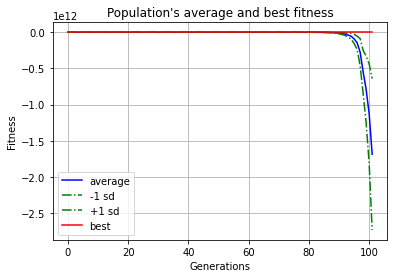

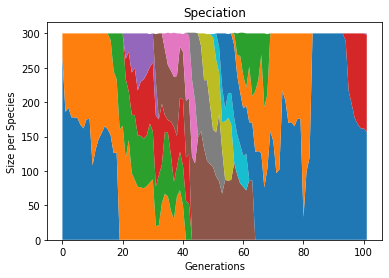

In [5]:
from __future__ import print_function
import os
import neat
import yt
import copy
import warnings
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import yt.visualization.eps_writer as eps
from yt.data_objects.particle_filters import add_particle_filter

xor_inputs = [[0.0, 0.0], (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)]
xor_outputs = [   (0.0,),     (1.0,),     (1.0,),     (0.0,)]
def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())
    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")
    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_spikes(spikes, view=False, filename=None, title=None):
    t_values = [t for t, I, v, u, f in spikes]
    v_values = [v for t, I, v, u, f in spikes]
    u_values = [u for t, I, v, u, f in spikes]
    I_values = [I for t, I, v, u, f in spikes]
    f_values = [f for t, I, v, u, f in spikes]
    fig = plt.figure()
    plt.subplot(4, 1, 1)
    plt.ylabel("Potential (mv)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, v_values, "g-")

    if title is None:
        plt.title("Izhikevich's spiking neuron model")
    else:
        plt.title("Izhikevich's spiking neuron model ({0!s})".format(title))

    plt.subplot(4, 1, 2)
    plt.ylabel("Fired")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, f_values, "r-")
    plt.subplot(4, 1, 3)
    plt.ylabel("Recovery (u)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, u_values, "r-")
    plt.subplot(4, 1, 4)
    plt.ylabel("Current (I)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, I_values, "r-o")

    if filename is not None:
        plt.savefig(filename)

    if view:
        plt.show()
        plt.close()
        fig = None

    return fig


def plot_species(statistics, view=False, filename='speciation.svg'):
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T
    fig, ax = plt.subplots()
    ax.stackplot(range(num_generations), *curves)
    plt.title("Speciation")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")
    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,node_colors=None, fmt='svg'):
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict
    node_attrs = {'shape': 'circle','fontsize': '9','height': '0.2','width': '0.2'}
    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)
    inputs = set()

    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled','shape': 'box'}
        input_attrs['fillcolor'] = node_colors.get(k, 'lightgray')
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled'}
        node_attrs['fillcolor'] = node_colors.get(k, 'lightblue')
        dot.node(name, _attributes=node_attrs)

    if prune_unused:
        connections = set()
        for cg in genome.connections.values():
            if cg.enabled or show_disabled:
                connections.add((cg.in_node_id, cg.out_node_id))

        used_nodes = copy.copy(outputs)
        pending = copy.copy(outputs)
        while pending:
            new_pending = set()
            for a, b in connections:
                if b in pending and a not in used_nodes:
                    new_pending.add(a)
                    used_nodes.add(a)
            pending = new_pending
    else:
        used_nodes = set(genome.nodes.keys())

    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled','fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)
    return dot


def eval_genomes(genomes, config):
    global a , b , c
    for genome_id, genome in genomes:
        if (genome_id < a) and (c > 3.9):
            b = b *1.5
            c = 0
        a = genome_id
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        #gpus = tf.config.experimental.list_logical_devices('GPU')
        for xi, xo in zip(xor_inputs, xor_outputs):
            #with tf.device(gpus[xor_outputs.index(xo)%4]):
                output = net.activate(xi)
                genome.fitness -= b*((output[0] - xo[0]) ** 2)
        if ( genome.fitness > 3.9):
            c = genome.fitness

def run(config_file):
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,neat.DefaultSpeciesSet, neat.DefaultStagnation,config_file)
    p = neat.Population(config)

    #p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    winner = p.run(eval_genomes,50)
    p.add_reporter(neat.Checkpointer(10))
    winner = p.run(eval_genomes,50)
    p.add_reporter(neat.Checkpointer(2))
    winner = p.run(eval_genomes,2)
    print('\nBest genome:\n{!s}'.format(winner))
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(xor_inputs, xor_outputs):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    #node_names = {-1:'A', -2: 'B', 0:'A XOR B'}
    draw_net(config, winner, True)#, node_names=node_names
    plot_stats(stats, ylog=False, view=True)
    plot_species(stats, view=True)
    #p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-99')
    #winner = p.run(eval_genomes, 1)
    #print(winner)



if __name__ == '__main__':
    a = 1
    b = 1
    c = 1
    local_dir = os.path.dirname("__file__")
    config_path = os.path.join(local_dir, '/content/config-feedforward.txt')
    print(config_path)
    run(config_path)